In [1]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install contextily

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calander
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat, lit, to_timestamp, year, month, dayofmonth, to_date, date_format, hour

In [4]:
yellow_19 = spark.read.load('raw_data/2019_Yellow_Taxi_Trip_Data.csv',format='csv', sep=',', inferSchema='true', header='true')
yellow_20 = spark.read.load('raw_data/2020_Yellow_Taxi_Trip_Data.csv',format='csv', sep=',', inferSchema='true', header='true')
yellow_21 = spark.read.load('raw_data/2021_Yellow_Taxi_Trip_Data.csv',format='csv', sep=',', inferSchema='true', header='true')

In [5]:
data = yellow_19.union(yellow_20.union(yellow_21))

In [6]:
data.dtypes

[('VendorID', 'string'),
 ('tpep_pickup_datetime', 'string'),
 ('tpep_dropoff_datetime', 'string'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'int'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('payment_type', 'int'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'double')]

In [7]:
data.select("tpep_pickup_datetime").show(truncate=False)

+----------------------+
|tpep_pickup_datetime  |
+----------------------+
|04/21/2019 11:22:07 PM|
|04/21/2019 11:51:32 PM|
|04/21/2019 09:54:40 PM|
|04/21/2019 11:27:19 PM|
|04/21/2019 11:02:16 PM|
|04/21/2019 11:01:45 PM|
|04/21/2019 11:18:05 PM|
|04/21/2019 11:23:28 PM|
|04/21/2019 11:34:37 PM|
|04/21/2019 11:41:49 PM|
|04/21/2019 11:53:11 PM|
|04/21/2019 11:54:00 PM|
|04/21/2019 11:33:59 PM|
|04/21/2019 11:53:51 PM|
|04/21/2019 11:30:40 PM|
|04/21/2019 11:53:07 PM|
|04/21/2019 11:10:07 PM|
|04/21/2019 11:49:19 PM|
|04/21/2019 11:20:02 PM|
|04/21/2019 11:11:10 PM|
+----------------------+
only showing top 20 rows



In [10]:
data = data.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime"), "MM/dd/yyyy hh:mm:ss a"))
data = data.withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime"), "MM/dd/yyyy hh:mm:ss a"))
data = data.withColumn("date", to_date(col("tpep_pickup_datetime")))
data = data.withColumn("time", hour(date_format('tpep_pickup_datetime', 'HH:mm:ss')))
data = data.withColumn("weekday", date_format(col("tpep_pickup_datetime"), "EEEE"))

In [11]:
#Getting Time Difference in Minutes using unix_timestamp()
from pyspark.sql.functions import *
data = data.withColumn('duration',(unix_timestamp("tpep_dropoff_datetime") - unix_timestamp('tpep_pickup_datetime'))/ 60)

In [12]:
data.select("duration").show()

+------------------+
|          duration|
+------------------+
| 6.133333333333334|
|              8.15|
|               9.6|
|12.433333333333334|
|              24.0|
| 7.883333333333334|
|              7.15|
| 3.533333333333333|
|1.8666666666666667|
|               5.1|
|15.683333333333334|
| 7.583333333333333|
|              9.65|
| 3.716666666666667|
|17.016666666666666|
|23.566666666666666|
|               6.8|
|              4.15|
|12.716666666666667|
|               5.8|
+------------------+
only showing top 20 rows



In [13]:
data = data.withColumn("tip_percent", col("tip_amount")/ col("total_amount") * 100)

In [14]:
data.select("tip_percent").show()

+------------------+
|       tip_percent|
+------------------+
|               0.0|
|              20.0|
|               0.0|
|16.618075801749274|
| 11.82033096926714|
|              10.0|
|16.666666666666664|
| 10.75268817204301|
|               0.0|
|               0.0|
|16.233766233766232|
|               0.0|
|6.9930069930069925|
|              20.0|
| 19.98341625207297|
| 19.94715984147952|
|16.666666666666668|
|               0.0|
|16.621253405994548|
|               0.0|
+------------------+
only showing top 20 rows



In [15]:
data = data.withColumn("year", year(data.date))

In [16]:
data.select("year").show()

+----+
|year|
+----+
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
+----+
only showing top 20 rows



In [17]:
data.dtypes

[('VendorID', 'string'),
 ('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'int'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('payment_type', 'int'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'double'),
 ('date', 'date'),
 ('time', 'int'),
 ('weekday', 'string'),
 ('duration', 'double'),
 ('tip_percent', 'double'),
 ('year', 'int')]

In [18]:
yellow_19 = data.filter(data.year == 2019)
yellow_20 = data.filter(data.year == 2020)
yellow_21 = data.filter(data.year == 2021)

In [19]:
# yellow_19.write.csv("/preprocessed_data/cleaned_19.csv")
# yellow_19.write.option("header",True).csv("preprocessed_data/data_2019")
# yellow_20.write.option("header",True).csv("preprocessed_data/data_2020")
# yellow_21.write.option("header",True).csv("preprocessed_data/data_2021")

In [20]:
# yellow_19.coalesce(5).write.option("header",True).csv("clean_data/data_2019")

In [21]:
# yellow_20.coalesce(10).write.option("header",True).csv("clean_data/data_2020")

In [22]:
# yellow_21.coalesce(100).write.option("header",True).csv("clean_data/data_2021")

In [23]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as ctx
import warnings

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

In [24]:
# Read in the taxi zone shapefile
sf = gpd.read_file('raw_data/taxi_zones/taxi_zones.shp')
zone = pd.read_csv("raw_data/taxi_zone_lookup.csv")
sf['geometry'] = sf['geometry'].to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

In [25]:
# yellow_data = yellow_19.toPandas()
#portion_19 = yellow_19.sample(fraction = 0.1)

In [26]:
#portion_19 = portion_19.toPandas()
pu_zone = data.groupBy('PULocationID').count()
do_zone = data.groupBy('DOLocationID').count()

In [27]:
pu_zone = pu_zone.toPandas()

In [28]:
do_zone = do_zone.toPandas()

In [29]:
pu_zone = gpd.GeoDataFrame(pd.merge(pu_zone, sf, left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
do_zone = gpd.GeoDataFrame(pd.merge(do_zone, sf, left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)
pu_zone = pu_zone.to_crs(epsg=3857)
do_zone = do_zone.to_crs(epsg=3857)

In [30]:
pu_zone

,PULocationID,count,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,148.0,607691,148,0.039131,0.000070,Lower East Side,Manhattan,"POLYGON ((-8235914.342 4971163.445, -8235980.7..."
1,243.0,17858,243,0.094331,0.000438,Washington Heights North,Manhattan,"POLYGON ((-8230024.211 4993124.052, -8230007.4..."
2,31.0,968,31,0.096425,0.000334,Bronx Park,Bronx,"POLYGON ((-8223275.940 4991311.185, -8223275.8..."
3,137.0,971214,137,0.046108,0.000116,Kips Bay,Manhattan,"POLYGON ((-8234547.238 4974126.181, -8234549.5..."
4,85.0,6938,85,0.057475,0.000144,Erasmus,Brooklyn,"POLYGON ((-8231760.081 4961673.784, -8231746.0..."
...,...,...,...,...,...,...,...,...
255,187.0,138,187,0.126868,0.000421,Port Richmond,Staten Island,"MULTIPOLYGON (((-8252598.392 4959662.686, -825..."
256,204.0,123,204,0.101912,0.000641,Rossville/Woodrow,Staten Island,"POLYGON ((-8260269.664 4947016.276, -8260230.1..."
257,214.0,244,214,0.135300,0.000812,South Beach/Dongan Hills,Staten Island,"POLYGON ((-8247094.479 4952889.862, -8247000.9..."
258,199.0,25,199,0.077809,0.000289,Rikers Island,Bronx,"POLYGON ((-8225269.323 4982696.078, -8225241.3..."


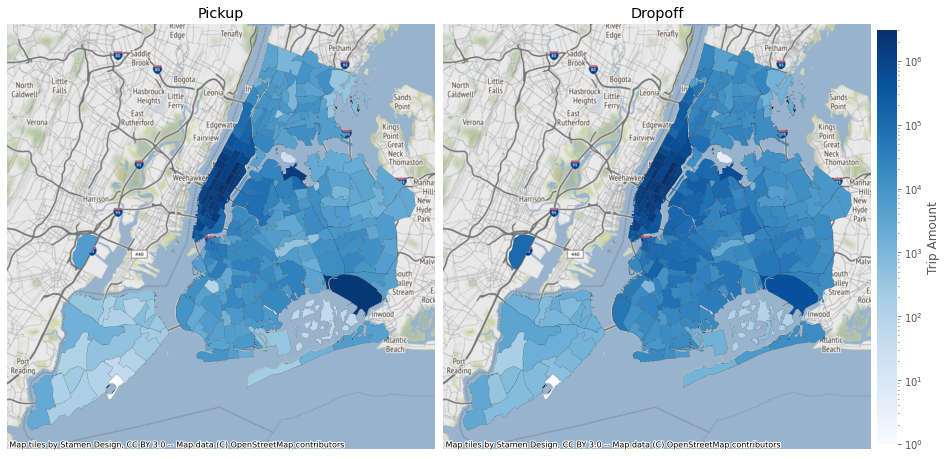

In [31]:
# plot geospatial visualisation to compare pickup and dropoff amount from each zone
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8, wspace=0.02, hspace=0.02)
# create a normalized colorbar
vmin, vmax = pu_zone['count'].min(), pu_zone['count'].max()
axs[0] = pu_zone.plot(column='count', linewidth=0.09, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[0]) 
ctx.add_basemap(axs[0])
vmin, vmax = do_zone['count'].min(), do_zone['count'].max()
axs[1] = do_zone.plot(column='count', linewidth=0.1, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[1])
ctx.add_basemap(axs[1])
axs[0].set_title('Pickup')
axs[1].set_title('Dropoff')
axs[0].set_axis_off()
axs[1].set_axis_off()
# draw the color bar
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Trip Amount')
plt.show()